In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [2]:
def prepare_datasets():
    
    npzfile = np.load('/content/drive/MyDrive/fma_mfcc/shuffled_train.npz') #change path
    print(npzfile.files)
    x_train = npzfile['arr_0']
    y_train = npzfile['arr_1']
    x_train = x_train[0:1000]
    y_train = y_train[0:1000]
    print(x_train.shape, y_train.shape)

    npzfile = np.load('/content/drive/MyDrive/fma_mfcc/shuffled_valid.npz') #change path
    print(npzfile.files)
    x_validation = npzfile['arr_0']
    y_validation = npzfile['arr_1']
    print(x_validation.shape, y_validation.shape)



    #x_train = x_train[... , np.newaxis]
    #x_validation = x_validation[... , np.newaxis]
    #x_test = x_test[... , np.newaxis]
    return x_train, x_validation, y_train, y_validation


In [3]:
x_train, x_validation, y_train, y_validation = prepare_datasets()

['arr_0', 'arr_1']
(1000, 10, 130, 13) (1000,)
['arr_0', 'arr_1']
(799, 10, 130, 13) (799,)


In [4]:
x_test ,  y_test =  x_validation, y_validation
#x_train = x_train[... , np.newaxis]
#x_test = x_test[... , np.newaxis]
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())


Training (1000, 10, 130, 13) 74.13542604597258
Testing (799, 10, 130, 13) 71.31276365835367


In [5]:
'''
Y_train = []
Y_test = []
for i in range(y_train.shape[0]):
  index = tf.argmax(y_train[i], axis=0)
  Y_train.append(index)
y_train = np.array(Y_train)
for i in range(y_test.shape[0]):
  index = tf.argmax(y_test[i], axis=0)
  Y_test.append(index)
y_test = np.array(Y_test)
print(y_train.shape, y_test.shape)
'''
print(y_train[2]) #check values

6


In [6]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [142, 111, 139, 119, 122, 109, 129, 129]
test groups: [100, 100, 100, 100, 100, 99, 100, 100]


In [7]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)
    
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)

In [12]:
#from kaggle notebook https://www.kaggle.com/kmader/image-similarity-with-siamese-networks
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
'''
n_layer = Conv2D(128, kernel_size = (4,4), activation = 'relu')(n_layer)
n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Conv2D(128, kernel_size = (1,1), activation = 'relu')(n_layer)
n_layer = MaxPool2D((1,1))(n_layer)
n_layer = Conv2D(256, kernel_size = (1,1), activation = 'relu')(n_layer)
n_layer = MaxPool2D((1,1))(n_layer)


n_layer = Flatten()(n_layer)
n_layer = Dense(300, activation = 'relu')(n_layer)
n_layer = Dropout(0.2)(n_layer)
n_layer = Dense(100, activation = 'relu')(n_layer)
n_layer = Dropout(0.2)(n_layer)
'''
for i in range(3):
    n_layer = Conv2D(8*2**i, kernel_size = (1,1), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (1,1), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)

feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 10, 130, 13)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 130, 8)        112       
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 130, 8)        32        
_________________________________________________________________
activation_15 (Activation)   (None, 10, 130, 8)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 130, 16)       144       
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 130, 16)       64        
_________________________________________________________________
activation_16 (Activation)   (None, 10, 130,

In [13]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 10, 130, 13) 0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 10, 130, 13) 0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           37840       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationM

In [14]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])

def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 26s 13ms/step - loss: 0.7240 - acc: 0.4919 - val_loss: 0.6923 - val_acc: 0.5127
Epoch 2/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6955 - acc: 0.5000 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 3/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6929 - acc: 0.5093 - val_loss: 0.6926 - val_acc: 0.5088
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6909 - acc: 0.5200 - val_loss: 0.6868 - val_acc: 0.5449
Epoch 5/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6857 - acc: 0.5371 - val_loss: 0.6817 - val_acc: 0.5610
Epoch 6/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6828 - acc: 0.5574 - val_loss: 0.6674 - val_acc: 0.6045
Epoch 7/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6793 - acc: 0.5674 - val_loss: 0.6636 - val_acc: 0.6084
Epoch 8/10
500/500 [==============================] - 5s 10ms/step -

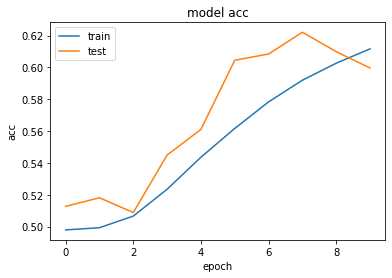

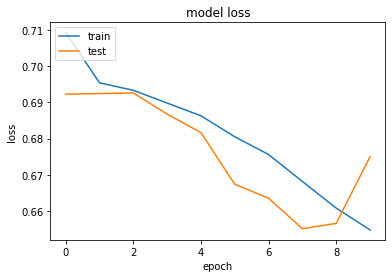

In [15]:
plt.plot(loss_history.history['acc'])
plt.plot(loss_history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()